# Convolutional Neural Network

In [3]:
import pandas as pd
from finlab.data import Data
data = Data()
twii = data.get("發行量加權股價指數")
twii = twii['台股指數']
twii = twii.resample('15T').first().dropna()

In [4]:
#t1 = indexes.tolist()
#print(indexs)

## 製作features

In [5]:
import numpy as np
import tqdm
time_period = 200

cnn_x = []
cnn_y = []
indexs = []
for i in tqdm.tqdm_notebook(range(0, len(twii) - time_period - 1 - 11, 3)):
    s = twii.iloc[i:i+time_period].values
    cnn_x.append((s - s.min())/(s.max() - s.min()))
    r = twii.iloc[i+time_period+10] / twii.iloc[i+time_period-1]
    cnn_y.append(r)
    indexs.append(twii.index[i+time_period-1])

cnn_x = np.array(cnn_x)
cnn_y = np.array(cnn_y)
indexes = np.array(indexs)




C:\Users\orang\.conda\envs\finlab\lib\site-packages\ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/26948 [00:00<?, ?it/s]

In [6]:
from ipywidgets import interact

@interact(x=(0, 100, 10))
def p(x=80):
    pass

interactive(children=(IntSlider(value=80, description='x', step=10), Output()), _dom_classes=('widget-interact…

## Reshape features and labels

In [7]:
cnn_x = cnn_x.reshape(len(cnn_x), time_period, 1)
cnn_y = cnn_y.reshape(len(cnn_y), 1)

## Split traning and testing data

In [8]:
import datetime
cnn_x_train = cnn_x[indexes < datetime.datetime(2021,1,1)]
cnn_y_train = cnn_y[indexes < datetime.datetime(2021,1,1)]

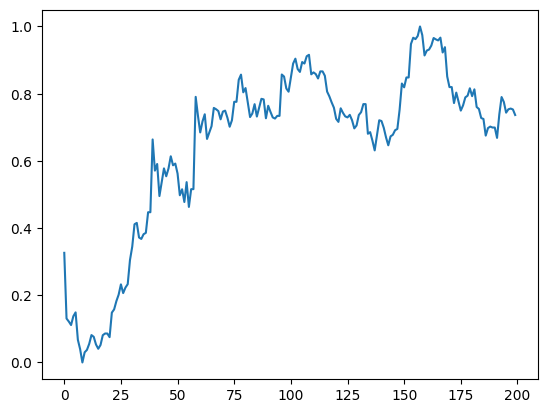

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(cnn_x[0].reshape(1, len(cnn_x[0]))[0])


## CNN

In [10]:
from tensorflow import keras
from tensorflow.keras import layers

input_shape = cnn_x[0].shape
time_period = 200
num_classes = 1

model = keras.Sequential()

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu', input_shape=cnn_x[0].shape))
model.add(layers.AveragePooling1D(5))

model.add(layers.Conv1D(filters=20, kernel_size=20, activation='relu'))
model.add(layers.AveragePooling1D(5))
model.add(layers.Flatten())
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=1, ))#activation = 'softmax'))

adam = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.01, amsgrad=False)

model.compile(loss='mse',
                optimizer=adam)

print(model.summary())

history = model.fit(cnn_x_train, cnn_y_train,
                    batch_size=200,
                    epochs=500,
                    verbose=1,
                    validation_split=0.1,
                    #callbacks=[get_best_model]
                   )

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 181, 20)           420       
_________________________________________________________________
average_pooling1d (AveragePo (None, 36, 20)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 20)            8020      
_________________________________________________________________
average_pooling1d_1 (Average (None, 3, 20)             0         
_________________________________________________________________
flatten (Flatten)            (None, 60)                0         
_________________________________________________________________
dense (Dense)                (None, 120)               7320      
_________________________________________________________________
dropout (Dropout)            (None, 120)               0

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\orang\.conda\envs\finlab\lib\site-packages\IPython\core\interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\orang\AppData\Local\Temp\ipykernel_13040\3893655489.py", line 35, in <module>
    validation_split=0.1,
  File "C:\Users\orang\.conda\envs\finlab\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "C:\Users\orang\.conda\envs\finlab\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1103, in fit
    callbacks.on_train_batch_end(end_step, logs)
  File "C:\Users\orang\.conda\envs\finlab\lib\site-packages\tensorflow\python\keras\callbacks.py", line 440, in on_train_batch_end
    self._call_batch_hook(ModeKeys.TRAIN, 'end', batch, logs=logs)
  File "C:\Users\orang\.conda\envs\finlab\lib\site-packages\tensorflow\python\keras\callbacks.py", line 289, in _call_batch_hoo

TypeError: object of type 'NoneType' has no len()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(np.log(history.history['loss'][1:]))
plt.plot(np.log(history.history['val_loss']))

In [ ]:
ey = model.predict(cnn_x)
ey = pd.Series(ey.swapaxes(0, 1)[0], index=indexes)

In [ ]:

eq = twii[pd.to_datetime(indexes)]
gain = (eq.shift(-1) - eq)

signal = (ey > ey.quantile(0.9)).rolling(20).sum() > 0
eq = (gain[signal])['2022':].cumsum()
eq.plot()

In [ ]:
signal['2022':].astype(int).diff().abs().sum()

In [ ]:
eq.tail()

In [10]:
# 預測所有日期的漲跌幅度
predicted_returns = model.predict(cnn_x)



844/844 [==============================] - 1s 727us/step


In [11]:
# 找出符合條件的日期（假設要找出漲幅大於 2% 的日期）
threshold = 0.01
signal_dates = indexes[predicted_returns[:, 0] > (1 + threshold)]

# 輸出符合條件的日期
print(signal_dates)


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [59]:
predicted_returns_list = signal_dates.tolist()
predicted_returns_list

[Timestamp('2009-02-11 00:00:00'),
 Timestamp('2009-02-16 00:00:00'),
 Timestamp('2009-02-19 00:00:00'),
 Timestamp('2009-02-24 00:00:00'),
 Timestamp('2009-02-27 00:00:00'),
 Timestamp('2009-03-04 00:00:00'),
 Timestamp('2009-03-09 00:00:00'),
 Timestamp('2009-03-12 00:00:00'),
 Timestamp('2009-03-17 00:00:00'),
 Timestamp('2009-03-20 00:00:00'),
 Timestamp('2009-03-25 00:00:00'),
 Timestamp('2009-03-30 00:00:00'),
 Timestamp('2009-04-02 00:00:00'),
 Timestamp('2009-04-07 00:00:00'),
 Timestamp('2009-04-10 00:00:00'),
 Timestamp('2009-04-15 00:00:00'),
 Timestamp('2009-04-20 00:00:00'),
 Timestamp('2009-04-23 00:00:00'),
 Timestamp('2009-04-28 00:00:00'),
 Timestamp('2009-05-04 00:00:00'),
 Timestamp('2009-05-07 00:00:00'),
 Timestamp('2019-03-21 00:00:00'),
 Timestamp('2019-03-26 00:00:00'),
 Timestamp('2019-03-29 00:00:00'),
 Timestamp('2019-04-03 00:00:00')]

In [60]:
print(indexes[-10:])

[Timestamp('2023-02-22 00:00:00') Timestamp('2023-03-01 00:00:00')
 Timestamp('2023-03-06 00:00:00') Timestamp('2023-03-09 00:00:00')
 Timestamp('2023-03-14 00:00:00') Timestamp('2023-03-17 00:00:00')
 Timestamp('2023-03-22 00:00:00') Timestamp('2023-03-27 00:00:00')
 Timestamp('2023-03-30 00:00:00') Timestamp('2023-04-07 00:00:00')]
